<a href="https://colab.research.google.com/github/mohripan/Job-Interview-Analysis/blob/main/RAVDESS_emotions_speech_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the Dataset

To download the dataset, I save my Kaggle API Key in my google drive so I don't need to upload it everytime.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp '/content/gdrive/MyDrive/KaggleAPI/kaggle.json' kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 99% 427M/429M [00:19<00:00, 25.2MB/s]
100% 429M/429M [00:19<00:00, 22.9MB/s]


In [8]:
!mkdir ravdess

In [9]:
!unzip -q /content/ravdess-emotional-speech-audio.zip -d ravdess

# The Library

First, we need optuna to do hyperparameter tuning. After that, we also want to use librosa, which is already in google colab. But the problem here is, when I want to do data augmentation, librosa 0.10.2 (the original installed version of librosa in colab) has a little bit of a problem, so I need to install the 0.9.2. To look at the issue in detail, you can look at [here](https://github.com/CorentinJ/Real-Time-Voice-Cloning/issues/1166).

In [10]:
!pip install optuna
!pip uninstall -y librosa
!pip install librosa==0.9.2

Found existing installation: librosa 0.10.0.post2
Uninstalling librosa-0.10.0.post2:
  Successfully uninstalled librosa-0.10.0.post2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.6 MB/s eta 0:00:00


# EDA

The first thing I want to do is to listen one of the audio in my dataset and print out the labels. You can look at the detail of the dataset [here](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio), but here is a big picture of the dataset.

The RAVDESS dataset is designed for emotion classification. The dataset includes 24 actors who vocalize different emotions across various statements. The file naming convention provided in the dataset description contains the information you need to identify the emotion associated with each audio file.

Here's a quick summary of the filename identifiers, focusing on the emotion part:
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

For example, in the filename "03-01-06-01-02-01-12.wav":
- The "06" in the filename represents the emotion, which is "fearful" in this case.

In [11]:
import os
import random
import pandas as pd
from IPython.display import Audio

In [12]:
# Define the path to the dataset folder
dataset_path = '/content/ravdess'

# Define a mapping for emotion identifiers to emotion labels
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [13]:
# Initialize an empty list to store the audio file paths
audio_files = []

# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    
    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)
            audio_files.append(audio_path)

In [14]:
# Select a random audio file
random_audio_file = random.choice(audio_files)

# Extract the emotion identifier from the filename (4th part of the filename)
emotion_id = os.path.basename(random_audio_file).split('-')[2]

# Map the emotion identifier to the corresponding emotion label
emotion_label = emotion_mapping[emotion_id]

# Print the emotion label and play the audio
print(f"Emotion: {emotion_label}")
Audio(filename=random_audio_file)

Emotion: disgust


You can run the code above several times and match the emotion label and the sounds that you hear.

# Pre-processing The Dataset

After we saved the dataset, our next step is to preprocess the dataset. There are some process to preprocess the data before we feed it into the model. Those process are:
- Resampling
- Noise Reduction
- Trimming Silence
- Normalization

Our goal now is to preprocess the dataset and then save the preprocess into a different folder.

In [15]:
import os
import librosa
import soundfile as sf

Let's make a folder to save our preprocess dataset

In [16]:
!mkdir ravdess_preprocess

In [17]:
# Define the path to the dataset folder and the output folder for preprocessed audio files
dataset_path = '/content/ravdess'
output_path = '/content/ravdess_preprocess'

# Define the target sampling rate
target_sampling_rate = 22050

In [18]:
# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    output_actor_path = os.path.join(output_path, actor_folder)
    
    # Create the output folder for the current actor if it doesn't exist
    os.makedirs(output_actor_path, exist_ok=True)

    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            
            if audio_file.endswith('.wav'):
                audio_path = os.path.join(actor_path, audio_file)
                output_audio_path = os.path.join(output_actor_path, audio_file)

                # Load the audio file using librosa
                audio, sampling_rate = librosa.load(audio_path, sr=None)

                # Resample the audio to the target sampling rate
                if sampling_rate != target_sampling_rate:
                    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=target_sampling_rate)

                # Trim leading and trailing silence
                audio, _ = librosa.effects.trim(audio, top_db=30)

                # Normalize the amplitude
                audio = librosa.util.normalize(audio)

                # Save the preprocessed audio file
                sf.write(output_audio_path, audio, target_sampling_rate, format='wav')

Now, let us hear the preprocessing data

In [19]:
# Define the path to the dataset folder
dataset_path = '/content/ravdess_preprocess'

# Define a mapping for emotion identifiers to emotion labels
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [20]:
# Initialize an empty list to store the audio file paths
audio_files = []

# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    
    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)
            audio_files.append(audio_path)

In [21]:
# Select a random audio file
random_audio_file = random.choice(audio_files)

# Extract the emotion identifier from the filename (4th part of the filename)
emotion_id = os.path.basename(random_audio_file).split('-')[2]

# Map the emotion identifier to the corresponding emotion label
emotion_label = emotion_mapping[emotion_id]

# Print the emotion label and play the audio
print(f"Emotion: {emotion_label}")
Audio(filename=random_audio_file)

Emotion: calm


# Save the Dataset Into .csv File

After we did preprocessing dataset, we want to save the data to .csv file. You don't have to do this, but it will make the formatting easier.

In [22]:
# Define the path to the dataset folder
dataset_path = '/content/ravdess_preprocess'

# Define a mapping for emotion identifiers to emotion labels
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [23]:
# Initialize an empty list to store the data
data = []

# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    
    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            
            # Check if the file is an audio file (has a .wav extension)
            if audio_file.endswith('.wav'):
                audio_path = os.path.join(actor_path, audio_file)

                # Extract the emotion identifier from the filename (4th part of the filename)
                filename_parts = audio_file.split('-')
                if len(filename_parts) > 2:
                    emotion_id = filename_parts[2]

                    # Map the emotion identifier to the corresponding emotion label
                    emotion_label = emotion_mapping.get(emotion_id)

                    if emotion_label is not None:
                        # Append the audio path and emotion label to the data list
                        data.append([audio_path, emotion_label])

# Create a pandas DataFrame from the data list
df = pd.DataFrame(data, columns=['audio_path', 'emotion'])

# Display the first few rows of the DataFrame
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv('RAVDESS_emotion_labels.csv', index=False)

                                          audio_path    emotion
0  /content/ravdess_preprocess/Actor_11/03-01-04-...        sad
1  /content/ravdess_preprocess/Actor_11/03-01-08-...  surprised
2  /content/ravdess_preprocess/Actor_11/03-01-04-...        sad
3  /content/ravdess_preprocess/Actor_11/03-01-05-...      angry
4  /content/ravdess_preprocess/Actor_11/03-01-02-...       calm


# Feature Extraction
Feature extraction is an essential step in machine learning, especially for tasks involving complex data like audio. Raw data often contains a lot of irrelevant or redundant information that can negatively impact the performance of machine learning models. By extracting meaningful features from the raw data, we can represent the data more compactly and efficiently, which helps the model learn better and make more accurate predictions.

For speech and audio analysis, Mel-frequency cepstral coefficients (MFCCs) are a widely used set of features. MFCCs represent the spectral envelope of the audio signal, which captures the characteristics of the speaker's voice and the spoken content. By using MFCCs as input features, we can simplify the audio data while retaining the essential information required for the machine learning model to recognize patterns related to emotions in the audio signal.

In [24]:
import pandas as pd
import numpy as np
import librosa

In [25]:
# Load the DataFrame from the preprocessed .csv file
df = pd.read_csv('RAVDESS_emotion_labels.csv')

# Define the parameters for MFCC feature extraction
n_mfcc = 13
n_fft = 2048
hop_length = 512

In [26]:
def augment_audio(audio, sr, time_stretch_range=(-0.1, 0.1), pitch_shift_range=(-2, 2), noise_level_range=(0.001, 0.01)):
    # Time stretching
    rate = np.random.uniform(1 + time_stretch_range[0], 1 + time_stretch_range[1])
    audio = librosa.effects.time_stretch(audio, rate)

    # Pitch shifting
    n_steps = np.random.randint(pitch_shift_range[0], pitch_shift_range[1])
    audio = librosa.effects.pitch_shift(audio, sr, n_steps=n_steps)

    # Adding noise
    noise_level = np.random.uniform(noise_level_range[0], noise_level_range[1])
    noise = np.random.normal(0, noise_level, audio.shape)
    audio = audio + noise

    return audio

In [27]:
# Initialize an empty list to store the features
features = []

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    audio_path = row['audio_path']
    emotion = row['emotion']

    # Load the preprocessed audio file
    audio, _ = librosa.load(audio_path, sr=None)

    # Apply data augmentation
    augmented_audio = augment_audio(audio, sr=_)

    # Extract the MFCC features
    mfcc = librosa.feature.mfcc(y=augmented_audio, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # Calculate the mean MFCC features
    mean_mfcc = np.mean(mfcc, axis=1)
    mean_mfcc = np.pad(mean_mfcc, (0, 16 - n_mfcc), 'constant')

    # Append the mean MFCC features and the emotion label to the features list
    features.append(np.append(mean_mfcc, emotion))

<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=0.9462534223419756 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.time_stretch(audio, rate)
<ipython-input-26-baaad95e37ae>:8: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.pitch_shift(audio, sr, n_steps=n_steps)
<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=1.0920467776615326 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.time_stretch(audio, rate)
<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=1.0538485328598997 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.time_stretch(audio, rate)
<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=0.9160035674715501 as keyword

In [28]:
# Create a pandas DataFrame from the features list
feature_columns = [f'mfcc_{i + 1}' for i in range(16)] + ['emotion']
features_df = pd.DataFrame(features, columns=feature_columns)

# Display the first few rows of the features DataFrame
print(features_df.head())

# Save the features DataFrame to a CSV file
features_df.to_csv('RAVDESS_MFCC_features.csv', index=False)

                mfcc_1              mfcc_2              mfcc_3  \
0  -187.54293641591622   55.16071264501966  13.407640480898616   
1  -165.71588414242748  52.481235261122606   8.219972043653568   
2  -189.93592864497873    69.3962774605599  34.667249206560534   
3  -168.71543093090725  52.321085158189746   5.465376490072489   
4  -215.90109264059396  57.285770759792904  19.169172015690464   

               mfcc_4               mfcc_5               mfcc_6  \
0   3.561716662847409   -5.285392134867844  -2.8409519034719377   
1   6.498137272301019   -6.831918230978613   0.2012829521929616   
2  28.447741175592544    1.891038756302016    6.292016462680499   
3   8.384000071115583  -11.266367827550392  -16.781754856725794   
4   21.77724673225448    9.428937950815149    8.132379069158198   

                mfcc_7               mfcc_8               mfcc_9  \
0   -6.696674967860191  -10.365989136676717  -14.684661583718238   
1  -10.610418676208253   -7.708019236667471   -16.91626309530463

# Data Preparation

Finally, we want to split the dataset into training and test sets. We also want to encode our data. In this case, I use PyTorch to prepare my data. In here, I used StandardScaler from sklearn, and I want to save my scaler so I can just transform it into different dataset.

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pickle
from torch.utils.data import DataLoader, Dataset

In [30]:
# Load the features DataFrame from the .csv file
features_df = pd.read_csv('RAVDESS_MFCC_features.csv')

# Define the emotion mapping
emotion_mapping = {
    'neutral': 1,
    'calm': 2,
    'happy': 3,
    'sad': 4,
    'angry': 5,
    'fearful': 6,
    'disgust': 7,
    'surprised': 8
}

# Apply the emotion mapping to the 'emotion' column
features_df['emotion'] = features_df['emotion'].map(emotion_mapping)

In [31]:
# Separate features and labels
X = features_df.drop('emotion', axis=1)
y = features_df['emotion']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features
scaler = StandardScaler() # We might want to save it
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [32]:
# Define a custom PyTorch Dataset class for the emotion recognition data
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y.iloc[idx] - 1, dtype=torch.long)  # Subtract 1 to make the labels 0-indexed
        return features, label

In [33]:
# Instantiate the custom Dataset and DataLoader objects for the training and testing sets
train_dataset = EmotionDataset(X_train_normalized, y_train)
test_dataset = EmotionDataset(X_test_normalized, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Save the scaler

In [34]:
# Save the scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Let's Train a Machine Learning Model
Finally, after we have preprared the dataset, we will train the model. For this particular case, I will use Transformer architecture. I also try to make the model smaller to avoid overkill, and might update it later.

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import os
from tqdm import tqdm

from sklearn.model_selection import KFold
from itertools import product

In [145]:
# Define the Transformer model
class ConformerBlock(nn.Module):
    def __init__(self, d_model, nhead, kernel_size, expansion_factor):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.self_attn = nn.MultiheadAttention(d_model, nhead)
        self.norm2 = nn.LayerNorm(d_model)
        self.conv1 = nn.Conv1d(d_model, d_model * expansion_factor, 1)
        self.depthwise_conv = nn.Conv1d(d_model * expansion_factor, d_model * expansion_factor, kernel_size, padding=kernel_size // 2, groups=d_model * expansion_factor)
        self.conv2 = nn.Conv1d(d_model * expansion_factor, d_model, 1)
        self.norm3 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * expansion_factor),
            nn.ReLU(),
            nn.Linear(d_model * expansion_factor, d_model)
        )

    def forward(self, x):
        # Self-attention
        residual = x
        x = self.norm1(x)
        x, _ = self.self_attn(x, x, x)
        x += residual

        # Convolution
        residual = x
        x = self.norm2(x)
        x = x.transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.depthwise_conv(x))
        x = self.conv2(x)
        x = x.transpose(1, 2)
        x += residual

        # Feed-forward
        residual = x
        x = self.norm3(x)
        x = self.feed_forward(x)
        x += residual

        return x

In [146]:
class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers, d_model, nhead, kernel_size, expansion_factor, dropout_rate = 0.5):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, d_model)
        
        self.conformer_layers = nn.ModuleList([
            ConformerBlock(d_model, nhead, kernel_size, expansion_factor) for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embedding(x)

        for layer in self.conformer_layers:
            x = layer(x)

        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [147]:
# Instantiate the model
input_dim = X_train.shape[1]
nhead = 4
num_layers = 4
d_model = 256
kernel_size = 3
expansion_factor = 2
num_classes = len(y.unique())
model = EmotionClassifier(input_dim, num_classes, num_layers, d_model, nhead, kernel_size, expansion_factor)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EmotionClassifier(
  (embedding): Linear(in_features=16, out_features=256, bias=True)
  (conformer_layers): ModuleList(
    (0-3): 4 x ConformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (conv1): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (depthwise_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
      (conv2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
      (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
      )
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features

## Hyperparameter Tuning

In [148]:
# Define hyperparameter grid
lr_grid = [0.001, 0.0005]
num_layers_grid = [2, 3]
dim_feedforward_grid = [64, 128]

In [149]:
# Perform grid search
param_grid = list(product(lr_grid, num_layers_grid, dim_feedforward_grid))

In [150]:
# Define K-fold cross-validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [151]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [152]:
def l2_regularizer(model, reg_factor):
    l2_reg = 0
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)
    return reg_factor * l2_reg

In [153]:
# Train the model
num_epochs = 50
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs, reg_factor = 1e-4):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch in pbar:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss += l2_regularizer(model, reg_factor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(train_loss=total_loss / len(train_loader))

        # Calculate validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(test_loader)

        # Update the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss

best_val_loss = float('inf')
best_params = None

for params in param_grid:
    lr, num_layers, dim_feedforward = params
    print(f'Training with learning rate: {lr}, num_layers: {num_layers}, dim_feedforward: {dim_feedforward}')

    val_loss_sum = 0
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X_train, y_train)):
        print(f'Fold {fold + 1}/{n_splits}')
        train_fold = torch.utils.data.Subset(train_dataset, train_idx)
        test_fold = torch.utils.data.Subset(train_dataset, test_idx)
        train_loader = DataLoader(train_fold, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_fold, batch_size=64, shuffle=True)

        model = EmotionClassifier(input_dim, num_classes, num_layers, d_model, nhead, kernel_size, expansion_factor)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=lr)

        val_loss = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)
        val_loss_sum += val_loss
        print(f'Fold {fold + 1}/{n_splits} Validation Loss: {val_loss}')

    avg_val_loss = val_loss_sum / n_splits
    print(f'Average Validation Loss: {avg_val_loss}')

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_params = params
      torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
      print(f'Saving best model with average validation loss: {best_val_loss}')

print(f'Best parameters: learning rate = {best_params[0]}, num_layers = {best_params[1]}, dim_feedforward = {best_params[2]}')
print(f'Best average validation loss: {best_val_loss}')


Training with learning rate: 0.001, num_layers: 2, dim_feedforward: 64
Fold 1/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 58.90it/s, train_loss=0.165]


Fold 1/5 Validation Loss: 1.4800588190555573
Fold 2/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 59.09it/s, train_loss=0.119]


Fold 2/5 Validation Loss: 1.7175649404525757
Fold 3/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 59.47it/s, train_loss=0.23]


Fold 3/5 Validation Loss: 1.5675828754901886
Fold 4/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 55.53it/s, train_loss=0.217]


Fold 4/5 Validation Loss: 1.6552135944366455
Fold 5/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 56.16it/s, train_loss=0.143]


Fold 5/5 Validation Loss: 1.5166970789432526
Average Validation Loss: 1.587423461675644
Saving best model with average validation loss: 1.587423461675644
Training with learning rate: 0.001, num_layers: 2, dim_feedforward: 128
Fold 1/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 47.31it/s, train_loss=0.133]


Fold 1/5 Validation Loss: 1.4939142167568207
Fold 2/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 47.09it/s, train_loss=0.174]


Fold 2/5 Validation Loss: 1.7023898661136627
Fold 3/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.62it/s, train_loss=0.0713]


Fold 3/5 Validation Loss: 1.557193398475647
Fold 4/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 54.40it/s, train_loss=0.121]


Fold 4/5 Validation Loss: 1.6285138726234436
Fold 5/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 35.75it/s, train_loss=0.153]


Fold 5/5 Validation Loss: 1.5026020407676697
Average Validation Loss: 1.5769226789474486
Saving best model with average validation loss: 1.5769226789474486
Training with learning rate: 0.001, num_layers: 3, dim_feedforward: 64
Fold 1/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, train_loss=0.233]


Fold 1/5 Validation Loss: 1.5680238902568817
Fold 2/5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.28it/s, train_loss=0.202]


Fold 2/5 Validation Loss: 1.7131233215332031
Fold 3/5


Epoch 28/50:  53%|█████▎    | 8/15 [00:00<00:00, 32.59it/s, train_loss=0.316]

In [125]:
# Save function
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load function
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))

# Post-processing and Visualization

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [127]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

In [128]:
def evaluate_model(model, test_loader, device):
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch in test_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            _, preds = torch.max(y_pred, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(y_batch.cpu().numpy())
    return all_preds, all_true

In [129]:
def plot_confusion_matrix(y_true, y_pred, class_names, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title="Confusion Matrix",
           ylabel="True label",
           xlabel="Predicted label")
    plt.show()

In [130]:
# Load the best model
best_model_path = "models/final_model.pth"
model = load_model(model, best_model_path, device)

In [132]:
# Evaluate the model
all_preds, all_true = evaluate_model(model, test_loader, device)
accuracy = accuracy_score(all_true, all_preds)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.4375


In [133]:
# Invert the emotion mapping
inverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}

In [134]:
# Display the classification report
class_names = np.array([inverse_emotion_mapping[i] for i in range(1, len(emotion_mapping) + 1)])
report = classification_report(all_true, all_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

     neutral       0.33      0.05      0.09        19
        calm       0.55      0.55      0.55        38
       happy       0.50      0.61      0.55        38
         sad       0.33      0.34      0.34        38
       angry       0.52      0.44      0.47        39
     fearful       0.27      0.46      0.34        39
     disgust       0.41      0.34      0.37        38
   surprised       0.65      0.51      0.57        39

    accuracy                           0.44       288
   macro avg       0.44      0.41      0.41       288
weighted avg       0.45      0.44      0.43       288



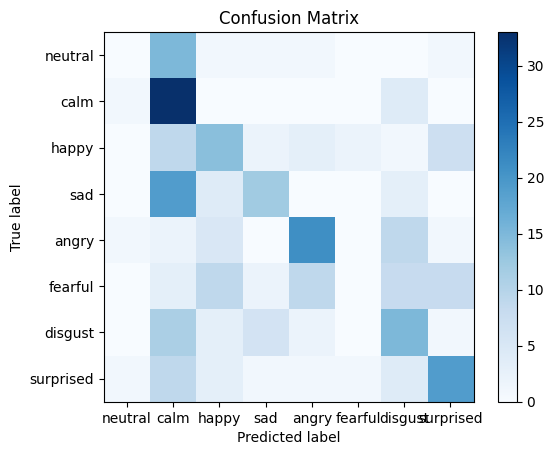

In [100]:
# Plot the confusion matrix
plot_confusion_matrix(all_true, all_preds, class_names)